# This notebook contains the model trained using the favored hyperparameters. 

# There are two additional notebooks used in this project, data_processing, which provides the steps used to create the data used in the experiment, and model_testing, wherein the hyperparameter values used in this notebook were determined. 

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

/home/zach/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-12-12 12:19:43.262240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 12:19:43.865500: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 12:19:43.865520: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on

# Import data from CSVs

In [2]:
# Read in data from CSV files
total_images = 1500
img_size = 256

train = pd.read_csv('datasets/train_set.csv',
                    usecols=['Image Index', 'Finding Label']
                   ).sample(int(total_images * 0.6), random_state=42)

test = pd.read_csv('datasets/test_set.csv', 
                    usecols=['Image Index', 'Finding Label']
                   ).sample(int(total_images * 0.2), random_state=42)

val = pd.read_csv('datasets/val_set.csv', 
                    usecols=['Image Index', 'Finding Label']
                   ).sample(int(total_images * 0.2), random_state=42)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Validation shape: {val.shape}")

Train shape: (900, 2)
Test shape: (300, 2)
Validation shape: (300, 2)


In [3]:
# Ensure that all classes are represented within the sets
print(len(train['Finding Label'].unique()) == len(test['Finding Label'].unique()))
print(len(train['Finding Label'].unique()) == len(val['Finding Label'].unique()))

True
True


In [4]:
# Read in image data and separate into images and labels
x_train = []
y_train = []

for index in train.index:
    fpath = train.loc[index, 'Image Index']
    x_train.append(cv2.resize(cv2.imread(f'images/{fpath}'), (img_size, img_size)))
    y_train.append(train.loc[index, 'Finding Label'])
    
x_test = []
y_test = []

for index in test.index: 
    fpath = test.loc[index, 'Image Index']
    x_test.append(cv2.resize(cv2.imread(f'images/{fpath}'), (img_size, img_size)))
    y_test.append(test.loc[index, 'Finding Label'])
    
x_val = []
y_val = []

for index in val.index: 
    fpath = val.loc[index, 'Image Index']
    x_val.append(cv2.resize(cv2.imread(f'images/{fpath}'), (img_size, img_size)))
    y_val.append(val.loc[index, 'Finding Label'])

In [5]:
# Cast images to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

In [6]:
# Apply min-max normalization to image arrays
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

In [7]:
# Apply one-hot encoding to image labels
y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)
y_val_encoded = pd.get_dummies(y_val)

In [8]:
# Tell model to stop training when validation loss stops improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

# Monitor trainging to periodically save the best result
monitor = tf.keras.callbacks.ModelCheckpoint('final_model.h5', 
                                             monitor='val_loss',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='min',
                                            )

In [9]:
lr = 1e-5

k = y_train_encoded.shape[1]

def model(my_shape=(img_size, img_size, 3), k=k, lr=lr):
    model_input = tf.keras.layers.Input(shape=my_shape)
    l1 = tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(model_input)
    l2 = tf.keras.layers.MaxPool2D((2,2))(l1)
    l3_drop = tf.keras.layers.Dropout(0.25)(l2)
    l4 = tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu')(l3_drop)
    l5 = tf.keras.layers.MaxPool2D((2,2))(l4)
    flat = tf.keras.layers.Flatten()(l5)
    l6 = tf.keras.layers.Dense(64, activation='relu')(flat)
    l7_drop = tf.keras.layers.Dropout(0.25)(l6)
    l8 = tf.keras.layers.Dense(32, activation='relu')(l7_drop)
    out = tf.keras.layers.Dense(k, activation='softmax')(l8)
    model = tf.keras.models.Model(inputs=model_input, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [10]:
classifier = model()
print(classifier.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                         

2022-12-12 12:20:06.374346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 12:20:06.374365: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 12:20:06.374381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zach-VivoBook-ASUSLaptop-X530FA-S530FA): /proc/driver/nvidia/version does not exist
2022-12-12 12:20:06.374538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
history = classifier.fit(x_train,
                      y_train_encoded,
                      batch_size=64,
                      epochs=250,
                      validation_data=(x_val, y_val_encoded),
                      callbacks=[early_stop, monitor]
                     )

2022-12-12 12:20:08.903275: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 707788800 exceeds 10% of free system memory.


Epoch 1/250


2022-12-12 12:20:10.421558: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.
2022-12-12 12:20:12.687558: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.


 1/15 [=>............................] - ETA: 57s - loss: 1.3863 - accuracy: 0.2812

2022-12-12 12:20:13.631728: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.
2022-12-12 12:20:16.065661: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 528515072 exceeds 10% of free system memory.


15/15 [==============================] - 53s 3s/step - loss: 1.3985 - accuracy: 0.2767 - val_loss: 1.3851 - val_accuracy: 0.2833
Epoch 2/250
15/15 [==============================] - 52s 3s/step - loss: 1.3904 - accuracy: 0.3111 - val_loss: 1.3838 - val_accuracy: 0.3000
Epoch 3/250
15/15 [==============================] - 52s 3s/step - loss: 1.3807 - accuracy: 0.3044 - val_loss: 1.3789 - val_accuracy: 0.2900
Epoch 4/250
15/15 [==============================] - 51s 3s/step - loss: 1.3843 - accuracy: 0.2922 - val_loss: 1.3788 - val_accuracy: 0.2733
Epoch 5/250
15/15 [==============================] - 52s 3s/step - loss: 1.3669 - accuracy: 0.3033 - val_loss: 1.3768 - val_accuracy: 0.2967
Epoch 6/250
15/15 [==============================] - 52s 3s/step - loss: 1.3867 - accuracy: 0.2633 - val_loss: 1.3692 - val_accuracy: 0.3367
Epoch 7/250
15/15 [==============================] - 51s 3s/step - loss: 1.3566 - accuracy: 0.3333 - val_loss: 1.3657 - val_accuracy: 0.3167
Epoch 8/250
15/15 [======

Epoch 59/250
15/15 [==============================] - 51s 3s/step - loss: 1.3043 - accuracy: 0.3711 - val_loss: 1.3352 - val_accuracy: 0.3767
Epoch 60/250
15/15 [==============================] - 51s 3s/step - loss: 1.3211 - accuracy: 0.3422 - val_loss: 1.3444 - val_accuracy: 0.3400
Epoch 61/250
15/15 [==============================] - 51s 3s/step - loss: 1.3138 - accuracy: 0.3422 - val_loss: 1.3340 - val_accuracy: 0.3700
Epoch 62/250
15/15 [==============================] - 51s 3s/step - loss: 1.3036 - accuracy: 0.3822 - val_loss: 1.3334 - val_accuracy: 0.3700
Epoch 63/250
15/15 [==============================] - 52s 3s/step - loss: 1.3182 - accuracy: 0.3378 - val_loss: 1.3288 - val_accuracy: 0.4000
Epoch 64/250
15/15 [==============================] - 51s 3s/step - loss: 1.3010 - accuracy: 0.3522 - val_loss: 1.3423 - val_accuracy: 0.3567
Epoch 65/250
15/15 [==============================] - 51s 3s/step - loss: 1.3119 - accuracy: 0.3522 - val_loss: 1.3384 - val_accuracy: 0.3200
Epoch 

Test loss (cross-entropy and accuracy): [1.3195439577102661, 0.39666667580604553]



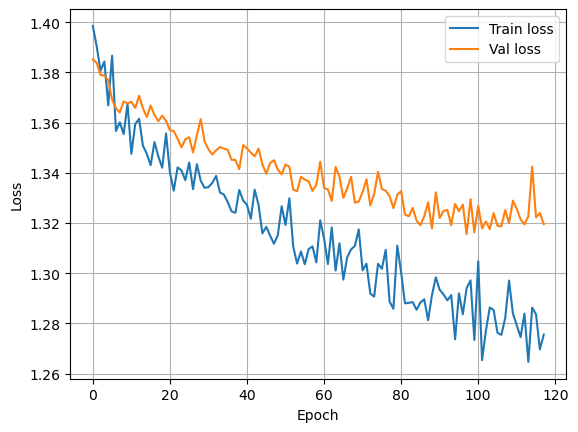

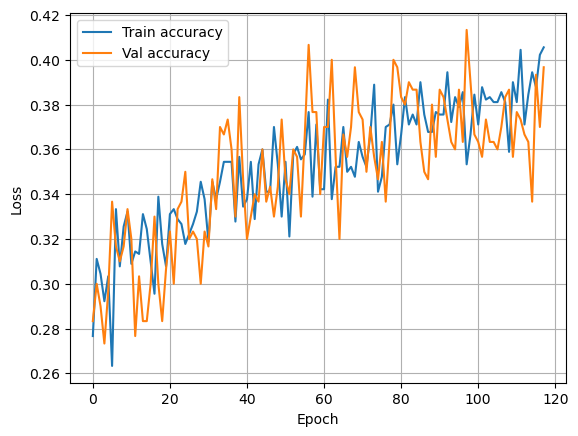

In [12]:
loss = classifier.evaluate(x_val, y_val_encoded, verbose=0)
print('Test loss (cross-entropy and accuracy):',loss)
print()

plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label = "Train accuracy")
plt.plot(history.history['val_accuracy'], label = "Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [13]:
classifier.save('(final)model_1e-5_d25_64.h5')
pd.DataFrame(history.history).to_csv('(final)model_1e-5_d25_64_hist.csv')